In [1]:
import numpy as np
import requests
from datetime import date
import time
import math
import os
import ast
import json
import matplotlib.pyplot as plt
import pandas as pd
import tqdm
import seaborn as sns
import folium
import geopandas as gpd
import fiona
from shapely.geometry import Point
%matplotlib inline

In [2]:
def log(response, logfile, output_path=os.getcwd()):
    """# Logging function to gather the log information"""
    # Open or create the csv file
    if os.path.isfile(logfile): #If the log file exists, open it and allow for changes     
        log = open(logfile,'a')
    else: #If the log file does not exist, create it and make headers for the log variables
        log = open(logfile,'w')
        header = ['timestamp','status_code','length','output_file']
        log.write(';'.join(header) + "\n") #Make the headers and jump to new line
        
    # Gather log information
    status_code = response.status_code #Status code from the request result
    timestamp = time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(time.time())) #Local time
    length = len(response.text) #Length of the HTML-string
    
    # Open the log file and append the gathered log information
    with open(logfile,'a') as log:
        log.write(f'{timestamp};{status_code};{length};{output_path}' + "\n") #Append the information and jump to new line

# Load housing data from Boligsiden API

In [3]:
year_from = 2000 # Determine start year
# municipality_codes = [101, 147] # codes for Copenhagen and Frederiksberg
# total_pages = [] # list to store pages

# base_url = 'https://api.boliga.dk/api/v2/sold/search/results'
# for i in range(0, len(municipality_codes)):
#     query_url = f'?propertyType=1,2,3,9&municipality={municipality_codes[i]}&salesDateMin={year_from}&salesDateMax=today&sort=date-d&page=1'
#     url1 = base_url + query_url
#     response = requests.get(url1, headers={'name':'Julius Løve fischer','email':'nbm205@alumni.ku.dk'}).json()
#     total_pages.append(response['meta']['totalPages'])

# print(response['meta'])

In [4]:
# query_urls = [] # list to contain query_urls for main data
# [[query_urls.append(f'?propertyType=1,2,3,9&municipality={municipality}&salesDateMin={year_from}&salesDateMax=today&sort=date-d&page={page_num}')\
#               for page_num in range(1, pages + 1)] for municipality, pages in zip(municipality_codes, total_pages)]

# query_urls_extra = [] # list to contain query_urls for extra housing information using Boliga BBR database
# [[query_urls_extra.append(f'?propertyType=1,2,3,9&municipality={municipality}&salesDateMin={year_from}&salesDateMax=today&sort=date-d&page={page_num}')\
#               for page_num in range(1, pages + 1)] for municipality, pages in zip(municipality_codes, total_pages)]

def scraper(base_url, query_urls, title, type = ''):
    logfile = f'log{title}.csv'
    df = pd.DataFrame()
    for query_url in tqdm.tqdm(query_urls):
        url = base_url + query_url
        try:
            response = requests.get(url, headers={'name':'Julius Løve fischer','email':'nbm205@alumni.ku.dk'})
        except Exception as e:
            print(url) #Print url
            print(f'An error has occured: {e}') #Print error
            df.to_csv(f'{title}.csv') #Save the dataframe as a csv file to retrieve at another time
            continue #Continue to next iteration of the loop
        
        if response.ok: #Check if the response carries any data
            result_json = response.json() #If the response carries data, then convert it to json format
        else: #If the response does not carry any data, then print the status_code and continue to next iteration of the loop
            print(f'Status code: {response.status_code}')
            continue
        
        if type == 'BBR':
            result_df = pd.Series(result_json) #Convert this iteration's json file to a series
            df = pd.concat([df,result_df], axis=1, ignore_index=True) #Append to the rest of the data
        else:
            result_df = pd.DataFrame(result_json['results']) #Convert this iteration's json file to a dataframe
            df = pd.concat([df,result_df], axis=0, ignore_index=True) #Append to the rest of the data
        log(response, logfile)
        time.sleep(0.1) #Sleep for 0.1 seconds
        
    if type == 'BBR':
        return df.transpose()
    else:
        return df

# houses = scraper(base_url, query_urls, 'houses')
    
# # houses.to_csv('houses.csv', index=False)

# Clean and transform data

In [5]:
houses = pd.read_csv('houses.csv')

column_selection = ['address', 'zipCode', 'price', 'soldDate', 'propertyType',
            'saleType', 'sqmPrice', 'rooms', 'size', 'buildYear', 'guid', 'latitude',
            'longitude', 'municipalityCode', 'city']

houses = houses[column_selection].query("saleType == 'Alm. Salg'") # select relevant columns and sale types
houses['unitId'] = houses['guid'].str.lower() # Convert to lower case for merging with bbr dataframe
houses['soldDate'] = pd.to_datetime(houses['soldDate'].astype(str)).dt.date
houses = houses.sort_values(by="soldDate", ascending = False) # Dataframe is not sorted by default as we have two query_lists
houses = houses.set_index('soldDate').drop('guid', axis=1)

In [6]:
# # Load housing specific details such as no. of bathrooms, energy label etc.

# base_url_bbr = 'https://api.boliga.dk/api/v2/bbrinfo/bbr' # Boliga BBR-register
# query_urls_bbr = '?id=' + geo_houses['guid'].to_numpy()
# bbr = scraper(base_url_bbr, query_urls_bbr[0:10], 'bbr', 'BBR')

# # Extracting relevant columns before creating parquet object to reduce file fize
# column_selection_bbr = ['unitId', 'addressFloor', 'ejendomsværdiskat', 'grundskyld', 'propertyTypeName',
#                         'bbrInfoBox', 'buildingInfo', 'unitInfo']
# bbr = bbr[column_selection_bbr]

# bbr.to_parquet('df.parquet1.gzip',
#               compression='gzip')

In [7]:
bbr = pd.read_parquet('df.parquet.gzip')
unpack_values = ['bbrInfoBox', 'buildingInfo', 'unitInfo']
for i in unpack_values:
    bbr = pd.concat([bbr, bbr[i].apply(ast.literal_eval).apply(pd.Series)], axis=1)
bbr = bbr.drop(unpack_values, axis=1)

In [8]:
####### GEM EVT. DEN HER FIL LOKALT SOM CSV-FIL, SÅ OG READ DEN, SÅ I IKKE SKAL KØRE HELE NOTEBOOKEN ######
houses = pd.merge(houses, bbr, on='unitId', how='inner') # Inner merge to discard NaN's, if any

# Datarens her

In [9]:
houses

,address,zipCode,price,propertyType,saleType,sqmPrice,rooms,size,buildYear,latitude,...,toiletQuantity,bathroomCode,bathroomQuantity,kitchenCode,energyCode,heatingInstallationCode,heatingCode,heatingSecondaryCode,usageCode,notes
0,"Gyldenlakvej 27, 1. tv",2300,2340000,3,Alm. Salg,41052.633,2.0,57,1938,55.645130,...,1,Badeværelse i enheden,1,Eget køkken med afløb,-,-,-,-,-,[]
1,"Gammel Kongevej 165A, 1",1850,5995000,3,Alm. Salg,66611.110,3.0,90,2000,55.677700,...,1,Badeværelse i enheden,1,Eget køkken med afløb,400 V el fra værk,-,-,-,-,[]
2,"Rolfsvej 37, 2. th",2000,7887000,3,Alm. Salg,71054.055,4.0,111,1916,55.683937,...,1,Badeværelse i enheden,1,Eget køkken med afløb,230 V el fra værk,-,-,-,-,[Excl. kælderrum 4 m2.]
3,"Havneholmen 82, 2. th",1561,5200000,3,Alm. Salg,68421.055,2.0,76,2008,55.661070,...,1,Badeværelse i enheden,1,Eget køkken med afløb,400 V el fra værk,-,-,-,-,[]
4,"Islands Brygge 24B, 4. tv",2300,7825000,3,Alm. Salg,74523.810,3.0,105,1910,55.663128,...,1,Badeværelse i enheden,1,Eget køkken med afløb,400 V el fra værk,-,-,-,-,[Andet areal er 5 m2 depotrum]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
88781,"Lykkesholms Allé 10, 2. th",1902,1850000,3,Alm. Salg,22289.156,4.0,83,1876,55.676643,...,1,Badeværelse i enheden,1,Eget køkken med afløb,-,-,-,-,-,[]
88782,"Lykkesholms Allé 10, 1",1902,1850000,3,Alm. Salg,14015.151,4.0,132,1876,55.676643,...,1,Badeværelse i enheden,1,Eget køkken med afløb,-,-,-,-,-,[]
88783,"Lykkesholms Allé 10, 2. tv",1902,1850000,3,Alm. Salg,108823.530,1.0,17,1876,55.676643,...,1,Hverken badeværelse eller adgang til badeværelse,0,Ingen fast kogeinstallation,-,-,-,-,-,[]
88784,"Rosenvængets Hovedvej 34, 2. th",2100,1300000,3,Alm. Salg,14130.435,3.0,92,1938,55.701344,...,1,Badeværelse i enheden,1,Eget køkken med afløb,-,-,-,-,-,[]


# Vi laver geopandas dataframe efter vi har renset hele dataframen

In [ ]:
points = houses.apply(lambda row: Point(row['longitude'], row['latitude']), axis = 1) # create housing points
geo_houses = gpd.GeoDataFrame(houses, geometry = points, crs = 'EPSG:4326') 
geo_houses.to_crs(epsg=25832, inplace=True) # this epsg code uses meters as unit measure
geo_houses

# Plots and descriptives

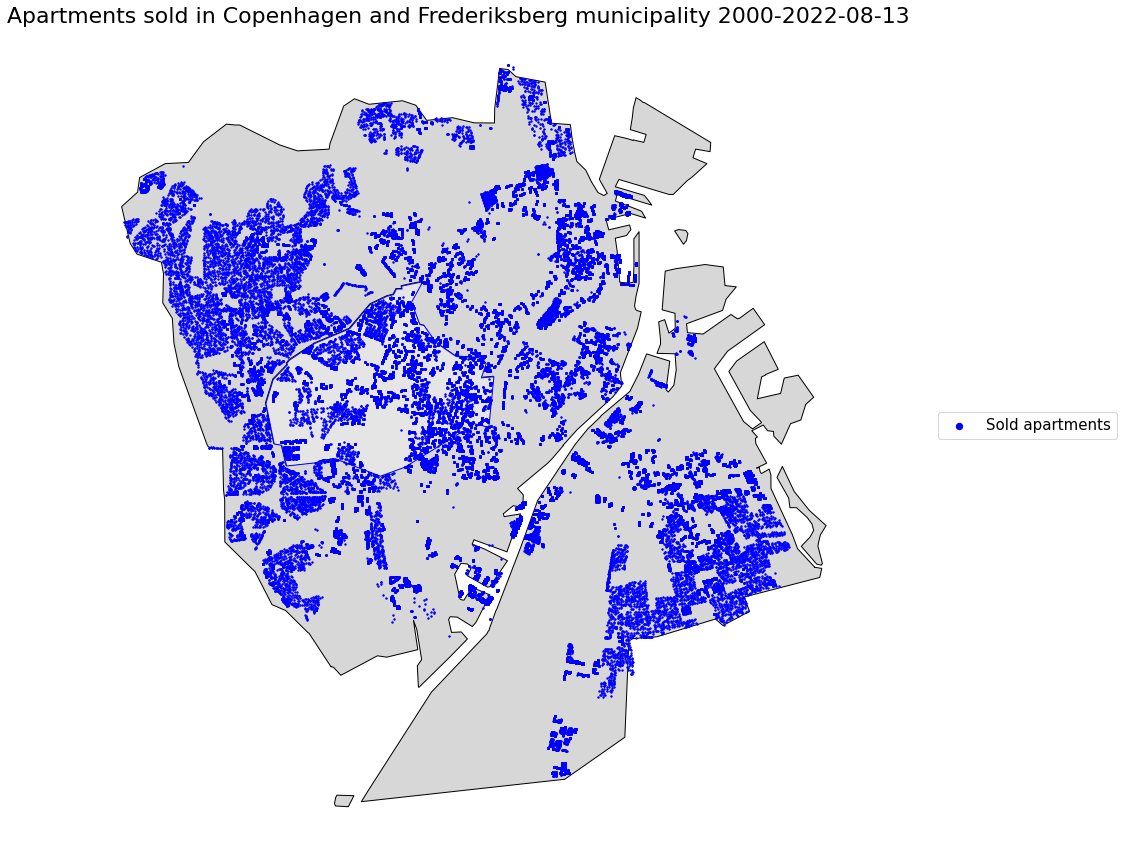

In [8]:
url = "https://raw.githubusercontent.com/ok-dk/dagi/master/geojson/kommuner.geojson"
kommuner = gpd.read_file(url)
kommuner.to_crs('epsg:25832', inplace=True) # this epsg code uses meters as unit measure
kommuner.columns = kommuner.columns.str.lower()
cph = kommuner[kommuner.komnavn.isin(['København'])].copy() # Store polygons for cph
frb = kommuner[kommuner.komnavn.isin(['Frederiksberg'])].copy() # Store polygons for frb


fig, ax = plt.subplots(figsize=(20, 15))

#cph municipality 
cph.plot(color='#d7d7d7',edgecolor='black', ax=ax, label = "CPH Municipality")

#frb municipality
frb.plot(color='#e5e5e5', edgecolor='blue',  ax=ax, label = "FRB Municipality")

#plot houseprices
geo_houses.plot(ax=ax, color = "blue", markersize=2,  label = "Sold apartments")


#narrow xlim
ax.set_xlim([716000, 730000])
ax.set_axis_off()
ax.set_title(f'Apartments sold in Copenhagen and Frederiksberg municipality {year_from}-{date.today()}', fontsize=22)

#handle legend 
lgnd = fig.legend(loc=7, ncol=1, fontsize = 15)    
lgnd.legendHandles[0]._sizes = [40]


fig.subplots_adjust(right=0.95) 